# Electroencephalography (EEG) signal processing

In this Jupyter notebook we will be analyzing an EEG data example. The data was obtained by Bisth et. al, the original publication can be accessed [here](https://www.sciencedirect.com/science/article/pii/S1746809419303593). EEG data was acquired with a TrueScan EEG System (Brainbox Inc.). Ag/AgCl electrodes were placed over the O1, O2, Oz and Pz in a 10-20 electrode placement configuration. A visual stimulus with dimensions of 3.5 by 3.5 cm and refresh rate of 7.5 Hz was generated in a computer monitor with a 60 Hz refresh rate. The subject was seated 70 cm away from the computer monitor. The stimulus shown to the subject for a 60 second period. The sampling rate of the EEG amplifier is
256 Hz, units are in $\mu\text{V}$.

## Import libraries
First, we will import all the necessary libraries to read and analyze the [EEG data](./eeg_data.csv).

In [1]:
## Import libraries
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch
import mne

## Import data

Then, we will import the [eeg_data.csv](./eeg_data.csv) file with the `pandas` module. The channels of interest are the following:
- Oz: 13
- Pz: 15
- O1: 18
- O2: 19

For this example, we will use O2.

In [2]:
## Settings
file_name = "eeg_data.csv"
srate =  256  # Sampling rate [Hz]

# Import data
raw_data = pd.read_csv(file_name, sep=" ", header=0)

# Extract EEG data and channel names
o2_raw = raw_data.iloc[:, 18].values

## Visualize raw data

Create a time vector and visualie the raw data.

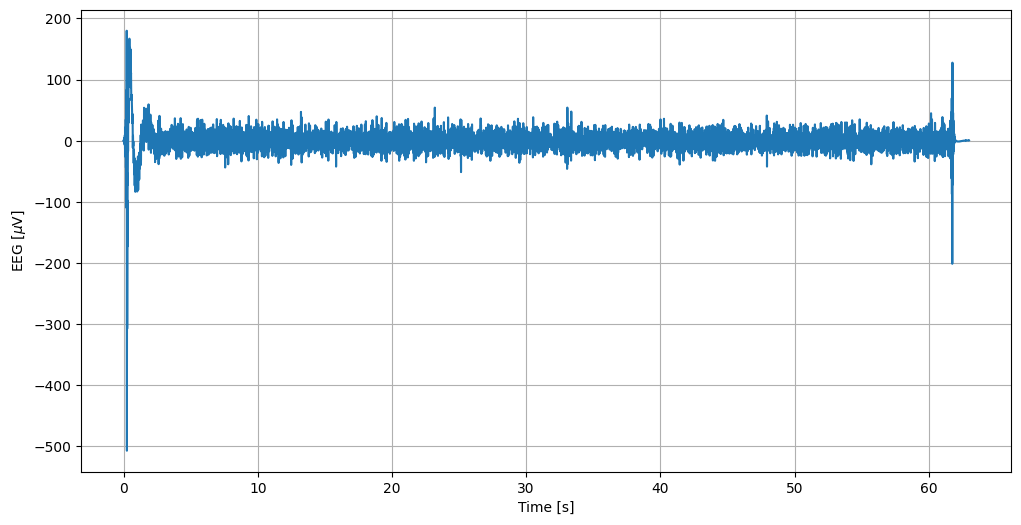

In [3]:
# Create time vector
time = np.linspace(0, len(o2_raw) / srate, len(o2_raw))

# Plot raw data
plt.figure(figsize=(12, 6))
plt.plot(time, o2_raw)
plt.xlabel("Time [s]")
plt.ylabel("EEG [$\mu$V]")
plt.grid()
plt.show()

## Trim data

Trim the beginning and end of the raw data remove artifacts not related to the experiment.

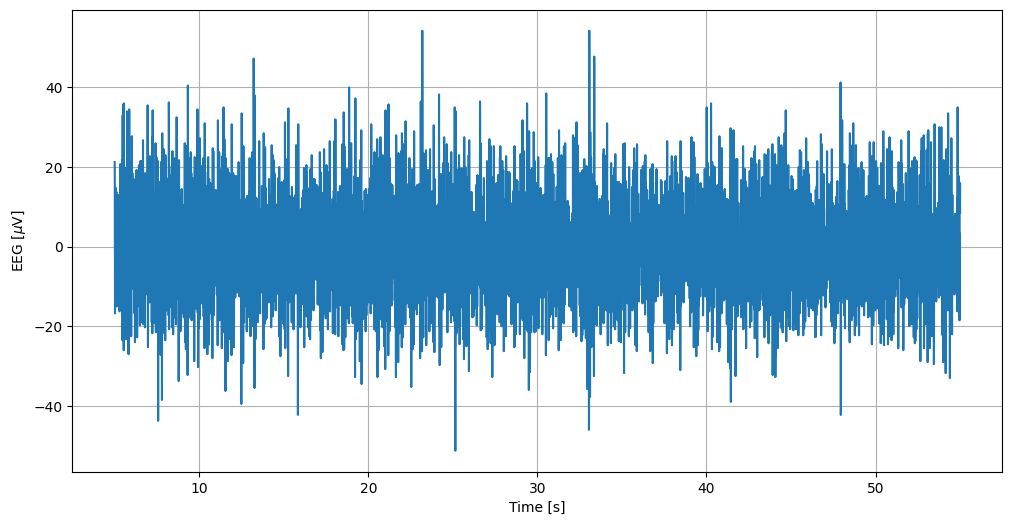

In [4]:
# Settings
trim_times = [5, 55]    # Start and end time for trimming [s]

# Trim data
time_mask = (time >= trim_times[0]) & (time <= trim_times[1])
trimmed_time = time[time_mask]
trimmed_o2_raw = o2_raw[time_mask]

# Plot trimmed data
plt.figure(figsize=(12, 6))
plt.plot(trimmed_time, trimmed_o2_raw)
plt.xlabel("Time [s]")
plt.ylabel("EEG [$\mu$V]")
plt.grid()
plt.show()

## Compute power spectral density
Compute the power sprectral density (PSD) of the raw data to determine if filters are needed.

The PSD, is computed with the following equation:
$$ PSD = \frac{|FFT(x)|^2}{\Delta f}

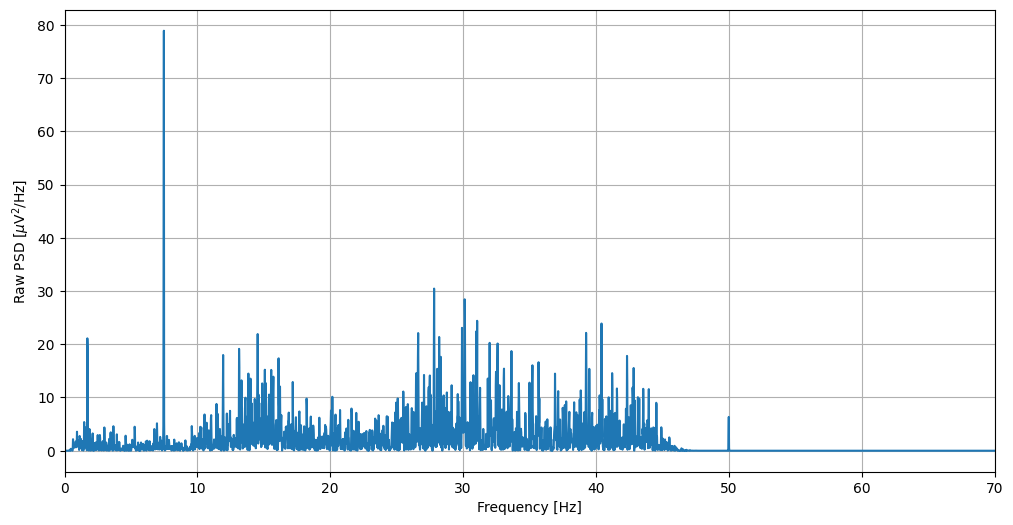

In [5]:
# Settings
freq_lims = [0, 70]  # Frequency limits for visualization [Hz]

[f, fft_raw] = welch(
    trimmed_o2_raw,
    fs = srate,
    nperseg = len(trimmed_o2_raw),
    )

# Plot FFT
plt.figure(figsize=(12, 6))
plt.plot(f, fft_raw)
plt.xlim(freq_lims)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Raw PSD [$\mu$V$^2$/Hz]")
plt.grid()
plt.show()


## Filter the data
Create and implement a 6th order band-pass Butterworth filter with cutoff frequencies of 0.5 and 30 Hz, plot the resulting spectrum

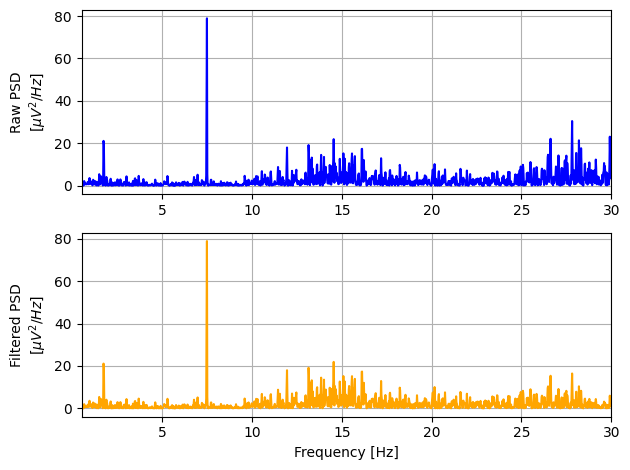

In [6]:
# Settings
fc = [0.5, 30]  # Cut-off frequencies [Hz]
order = 6  # Filter order

# Design filter
sos = butter(
    order,
    fc,
    fs = srate,
    btype = "bandpass",
    output = "sos"
)

# Apply filter
filtered_o2 = sosfiltfilt(sos, trimmed_o2_raw)

# Compute PSD of filtered data
[f, psd_filtered] = welch(
    filtered_o2,
    fs = srate,
    nperseg = len(filtered_o2),
    )

# Plot filtered data
[fig, ax] = plt.subplots(2, 1)

ax[0].plot(f, fft_raw, color="blue")
ax[0].set_ylabel("Raw PSD\n[$\mu V^2/Hz$]")
ax[0].set_xlim(fc)
ax[0].grid()


ax[1].plot(f, psd_filtered, color="orange")
ax[1].set_ylabel("Filtered PSD\n[$\mu V^2/Hz$]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_xlim(fc)
ax[1].grid()

plt.tight_layout()
plt.show()

## Compute modified signal-to-noise ratio (SNR)

The SNR gives us a metric of how "good" is our signal quality. This value can be represented as a ratio, or in decibels (dB). Where:
- Ratios higher than 1, or positive decibels: signal $>$ noise.
- Ratios smaller than 1 or negative decibels: noise $>$ signal.

To estimate the SNR in SSVEP signals, the modified SNR by Norcia et al., is commonly used. The detailed implementation can be found [here](https://jov.arvojournals.org/article.aspx?articleid=2291652). In short, the amplitude of the peak at the stimulation frequency and its harmonics is divided by a noise band before and after the stimulation frequency.

In [15]:
## Settings
ssvep_freq = 7.5    # SSVEP frequency [Hz]
nharmonics = 0      # Number of harmonics [n]
noise_band = 0.5    # Noise band +/- ssvep freq [Hz]

## Helper functions
def ssvep_snr(
    f:np.ndarray,
    pxx:np.ndarray,
    stim_freq:float,
    noise_band:float,
    nharms: int,
    db_out:bool
    ) -> float:
    """
        Computes an SSVEP SNR as described in `Norcia et al. 2015`

        Parameters
        ----------
            f: ndarray
                Frequency vector [Hz]
            pxx: ndarray
                Power spectrum of EEG signal [uV^2]
            stim_freq: float
                SSVEP stimulation frequency [Hz]
            noise_band: float
                Range of single sided noise band [Hz]
            nharms: int
                Number of harmonics to use 
            db_out: bool
                Boolean to output in dB
    """
    # Check if the input is a 1D or 2D array
    if (pxx.ndim == 1):
        pxx = np.expand_dims(pxx, axis=0)
    elif (pxx.ndim != 2):
        print("Warning: The input array does not have two dimensions.")
        return None
    
    if (pxx.shape[0] > pxx.shape[1]):
        pxx = pxx.T

    # Preallocate and initialize variables
    peaks_index = np.zeros(nharms+1)  # Peaks of SSVEP, including stimulation frequency
    pxx_signal = 0  # Signal power [V^2]
    pxx_noise = 0   # Noise power [V^2]
    fres = f[1]     # Frequency resolution [Hz]

    for h in range(nharms+1):
        norm_freq = np.abs(f-stim_freq*(h+1))
        peak_array = np.nonzero(norm_freq == np.min(norm_freq)) 
        peaks_index[h] = int(peak_array[0][0])    # Find peaks
        pxx_signal = pxx_signal + pxx[:,int(peaks_index[h])]

        noise_low = pxx[:,int(peaks_index[h]-np.floor(noise_band/fres)-1):int(peaks_index[h])-1]
        noise_high = pxx[:,int(peaks_index[h])+1:int(peaks_index[h]+np.floor(noise_band/fres)+1)]
        pxx_noise = pxx_noise + np.mean(np.concatenate([noise_low, noise_high], axis=1), axis=1)

    if db_out:
        return 10*np.log10(pxx_signal/pxx_noise)
    else:
        return pxx_signal/pxx_noise
    
# Compute SSVEP SNR
ssvep_snr_db = ssvep_snr(f, psd_filtered, ssvep_freq, noise_band, nharmonics, db_out=True)

# Print SNR result
print(f"SSVEP SNR: {ssvep_snr_db[0]:.2f} dB")


SSVEP SNR: 4.64 dB


## Process data with MNE

[MNE](https://mne.tools/stable/index.html) is a Python  library focused on processing EEG and MEG data.
In this section we will show the tool to plot RAW data, filter it, and compute the PSD.

### Create MNE raw data object

In [8]:
# Magic command to make interactive plots
%matplotlib qt

# Define channel information
ch_names = ["Oz", "Pz", "O1", "O2"]
ch_cols = [12, 14, 17, 18]  # Corresponding columns in the CSV file

# Create info object
info = mne.create_info(ch_names=ch_names, sfreq=srate, ch_types='eeg')

# Extract channels from raw_data, and scale to V
scale_factor = 1e-6
eeg_data = scale_factor * raw_data.iloc[:, ch_cols].T.values

# Create Raw object
raw = mne.io.RawArray(eeg_data, info, verbose=False)

# Set montage to standard 10-20 system
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

<RawArray | 4 x 16127 (63.0 s), ~516 KiB, data loaded>

### Plot raw data

Using matplotlib as 2D backend.


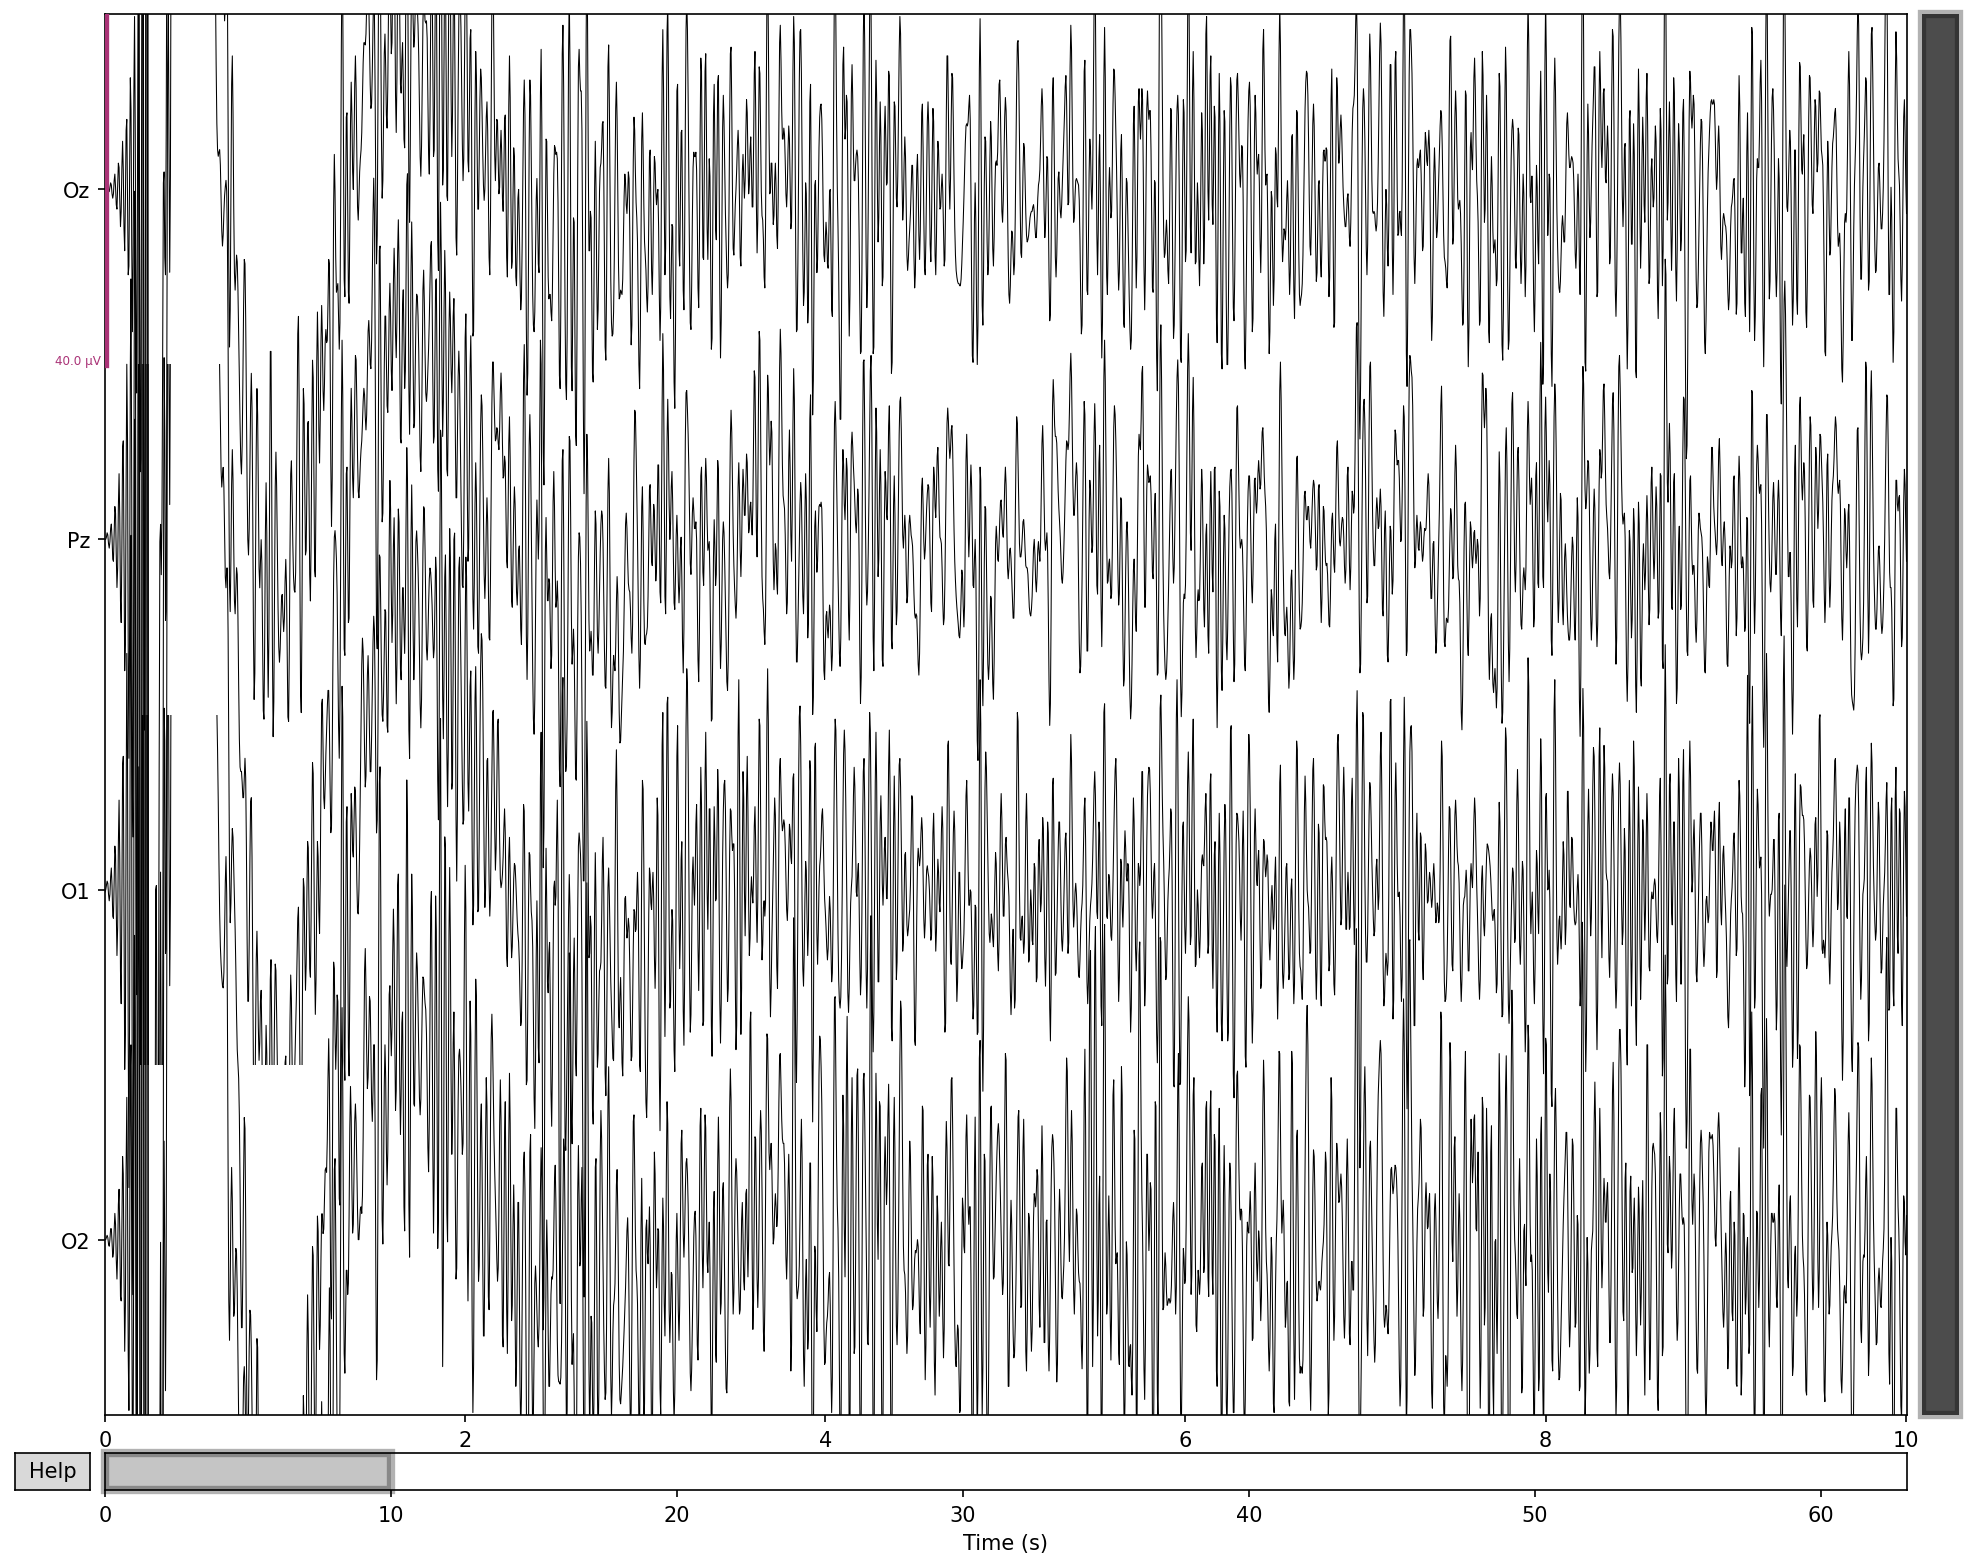

In [9]:
raw.plot()

### Filter data

Create and implement a 6th order band-pass Butterworth filter with cut-off frequencies of 0.5 and 30 Hz, plot the resulting spectrum

Plotting power spectral density (dB=False).


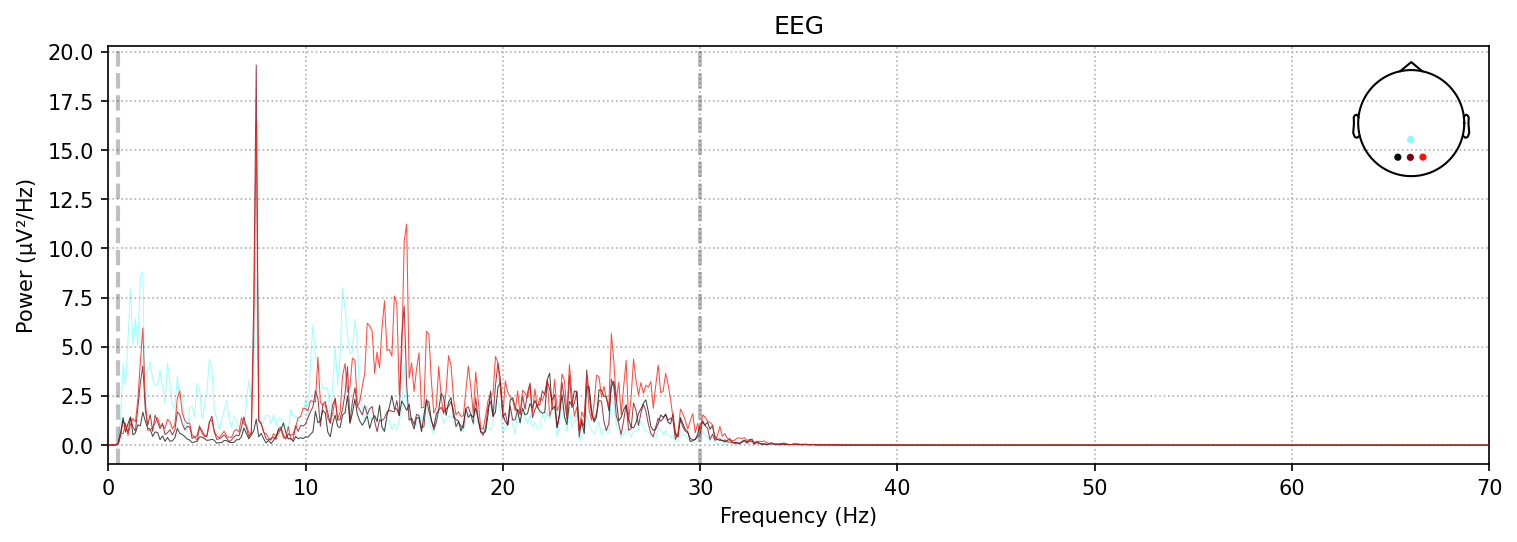

In [13]:
## Settings
fc = [0.5, 30]  # Cut-off frequencies [Hz]
order = 6  # Filter order
ftype = "butter"  # Filter type

mne_filtered = raw.copy()   # Create a copy of the raw data to avoid modifying the original

# Design and apply filter
mne_filtered.filter(
    l_freq = fc[0],     # Lower frequency bound
    h_freq = fc[1],     # Upper frequency bound
    picks = 'eeg',       # Only filter EEG channels
    method = 'iir',      # Use IIR (Butterworth) filter
    iir_params = dict(order = order, ftype = ftype),
    verbose = False
)

# Compute and plot PSD of filtered data
mne_filtered.compute_psd(    
    fmax = freq_lims[1],    # Maximum frequency for PSD computation
    tmin = trim_times[0],   # Start time for PSD computation
    tmax = trim_times[1],   # End time for PSD computation
    average = 'mean',       # Average across epochs
    picks = 'eeg',          # Only compute PSD for EEG channels
    verbose = False,
    ).plot(
        dB=False,  # Output in linear scale
        )

In [11]:
mne_filtered.get_data()[0]

array([-3.63989433e-09,  2.57524781e-08,  5.33305769e-08, ...,
        1.87902859e-08,  1.77234162e-08,  1.25964689e-08], shape=(16127,))